# Customer Retention by Providing the Right Incentive to the Right People
#### By Aparna Shasty

## Overview

+ Recognizing/defining the business problem
+ Data Wrangling
+ Exploratory Data Analysis (EDA) and Visualizations
+ Data Storytelling
+ Drawing inferences
+ Training and Testing Machine Learning models
+ Evaluating Feature Importance
+ Recommendations to retain the customers
+ Scope for future work

### 1) Business Problem

A telecom company has been affected by the increasing number of customers subscribing to the services of a competitor. It is much more expensive to attract new customer than retaining old customer. At the same time, spending too much on or spending on the wrong factor for retaining customer who has no intention to leave (or who was not leaving for that factor which was addressed) could be a waste of  money. Therefore it is important to identify the customer who has high probability of leaving and zero down on the reason for it. An analysis of the past records of the customers can give great insights on who might leave and what is the cause. The telecom company already has this data available and data scientist need not collect the data in this case. The data can be found in [IBM page](https://www.ibm.com/communities/analytics/watson-analytics-blog/guide-to-sample-datasets/) : [Telecom Dataset]('https://community.watsonanalytics.com/wp-content/uploads/2015/03/WA_Fn-UseC_-Telco-Customer-Churn.csv')

### Step by Step approach to Predicting and Preventing Customer Churn Rate
#### Quick Examination of the Dataset

In [1]:
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib as mpl
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns

import time
from scipy.stats import pearsonr

In [2]:
ch = pd.read_csv('https://community.watsonanalytics.com/wp-content/uploads/2015/03/WA_Fn-UseC_-Telco-Customer-Churn.csv')
ch_orig = ch.copy()
ch.info()
ch.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Note that,

Target (Dependent) Variable: **Churn**

Feature (Independent) Variables: 19 of them out of 21 shown above. Churn is target, Customer ID is just unique identity.

**First question to answer:** What percentage of the given dataset has data for customers who switch and what percentage is loyal?

Overall Customer Churn percentage in the given dataset is 26.54 %


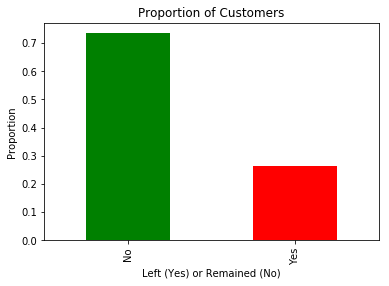

In [3]:
_ = (ch.groupby('Churn')['customerID'].count()/ch['customerID'].count()).plot.bar(color='gr')
_ = plt.title('Proportion of Customers')
_ = plt.ylabel('Proportion')
_ = plt.xlabel('Left (Yes) or Remained (No)')
print('Overall Customer Churn percentage in the given dataset is {} %'.format(round(ch.Churn.replace({'No':0,'Yes':1}).mean()*100,2)))

26.54% or 1869 of the 7043 records in the dataset belong to customers who switched to a competitor. This is a binary classification problem with moderately  imbalanced dataset. 

### 2) Data Wrangling
The output of the cell number 2 above gives all the data types and counts of non-null entries. Non-null does not mean valid entries. We need to ensure all of them have meaningful datatypes and valid entries. The TotalCharges is of type object, which means there is some non-numeric entry. It is expected to be float. Look at non-churn and churn group separately, as their dynamics might differ. Compute the I choose to impute the invalid entries with median of each group.

Senior Citizen is a category variable, however it is given as int. It need not be converted, as it will be eventually converted back to numeric.

In [4]:
pp = ch[ch.Churn=='Yes']
print('Number of Total Charges without valid numbers in Churn group:',pp.Churn[pp.TotalCharges == ' '].count())
pp = ch[ch.Churn=='No']
print('Number of Total Charges without valid numbers in No Churn group:',pp.TotalCharges[pp.TotalCharges == ' '].count())
median_total_charges = round(pp.TotalCharges.drop(pp.TotalCharges[pp.TotalCharges == ' '].index).astype(float).median(),2)
print('Median Total Charges not including invalid entries',median_total_charges)
mean_total_charges = round(pp.TotalCharges.drop(pp.TotalCharges[pp.TotalCharges == ' '].index).astype(float).mean(),2)
print('Mean Total Charges not including invalid entries',mean_total_charges)

Number of Total Charges without valid numbers in Churn group: 0
Number of Total Charges without valid numbers in No Churn group: 11
Median Total Charges not including invalid entries 1683.6
Mean Total Charges not including invalid entries 2555.34


The invalid entries are only in no Churn group. 
The huge difference in Mean and Median indicates that distribution is highly skewed. We have several options to impute it.
+ Fill with overall mean/median: Bad option, as the missing entries are in "No" group
+ Fill with mean of "No" group: OK option, but not ideal, as the total charges seems a skewed distribution which can be verified once imputation is done
+ Fill with median of "No" group: Better option for skewed distribution
+ Look for correlation of Total Charges with any other one or two predictor variables and if there is a linear relation, fit a regression model and predict the missing values. This seems the best in theory, however in this case, seems like an overkill as there are only 11 missing values.
+ Hence we choose to fill with median

In [5]:
ch.TotalCharges = ch.TotalCharges.apply(lambda x: median_total_charges  if x == ' ' else float(x))

All other variables are fine. Converting object data types to categories and doing one hot encoding are explained along the way. 
### 3) Exploratory Data Analysis (Numerical and Visual), Data Story Telling

We will understand the data better:

In [6]:
# Check the stats for numeic types
numvar = ['tenure','MonthlyCharges','TotalCharges']
ch.groupby('Churn')[numvar].describe().T

Churn                          No          Yes
tenure         count  5174.000000  1869.000000
               mean     37.569965    17.979133
               std      24.113777    19.531123
               min       0.000000     1.000000
               25%      15.000000     2.000000
               50%      38.000000    10.000000
               75%      61.000000    29.000000
               max      72.000000    72.000000
MonthlyCharges count  5174.000000  1869.000000
               mean     61.265124    74.441332
               std      31.092648    24.666053
               min      18.250000    18.850000
               25%      25.100000    56.150000
               50%      64.425000    79.650000
               75%      88.400000    94.200000
               max     118.750000   118.350000
TotalCharges   count  5174.000000  1869.000000
               mean   2553.490800  1531.796094
               std    2327.325414  1890.822994
               min      18.800000    18.850000
               25%     579.575000   134.500000
               50%    1683.600000   703.550000
               75%    4262.850000  2331.300000
               max    8672.450000  8684.800000

+ Mean tenure for Churn group is lower than the other group, which is as expected.
+ Mean Monthly charges are higher for Churn group, which is OK and could be one factor to address to minimize the Churn.
+ Mean Total Charges are lower for Churn group. It is not clear from the dataset what this means. If this is the cumulative charges from the date of subscription, then it is natural that loyal customers have longer tenure and hence they would end up paying the company more. When the real client is available for discussion, such questions can be clarified with the client.
+ The spread in the descriptive stats are very high, looking at std values and also the difference between max and min. This shows large disparity between customers. May be not an ideal thing.

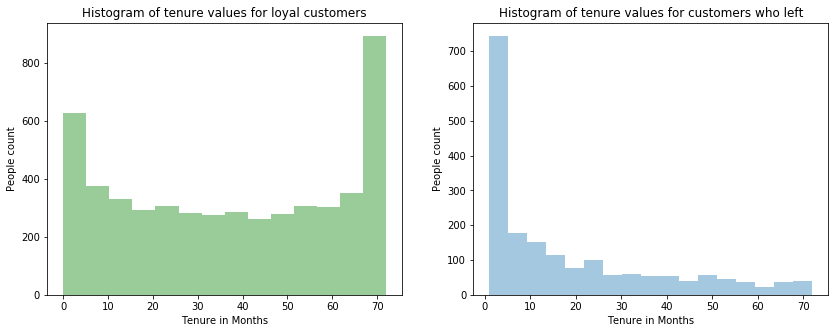

In [7]:
fig, ax = plt.subplots(figsize=(14,5))
_ = plt.subplot(1,2,1)
sns.distplot(ch.loc[ch.Churn=='No','tenure'],hist=True,color='g',kde=False)
_ = plt.title('Histogram of tenure values for loyal customers')
_ = plt.xlabel('Tenure in Months')
_ = plt.ylabel('People count')
_ = plt.subplot(1,2,2)
sns.distplot(ch.loc[ch.Churn=='Yes','tenure'],hist=True,kde=False)
_ = plt.title('Histogram of tenure values for customers who left')
_ = plt.xlabel('Tenure in Months')
_ = plt.ylabel('People count')

Mean Tenure of Two groups
 Churn
No     37.569965
Yes    17.979133
Name: tenure, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


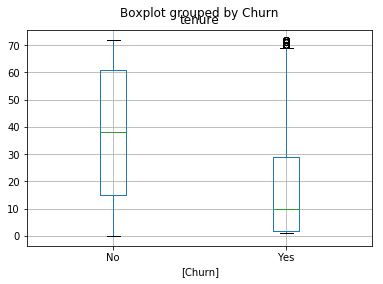

In [8]:
print("Mean Tenure of Two groups\n",ch.groupby('Churn').tenure.mean())
_ = plt.figure()
_ = ch[['Churn','tenure']].boxplot(by='Churn')

**Remarks: ** There is a clear distinction in the shape of the two histograms above. The percentiles are visible in the box plot. 
+ Customers who cut the contract (churn = 1) are highly concentrated towards lesser tenure (<= 4 years). The number of customers in each higher bin progressively reduces.That is exactly why this is Churn =1 group!
+ The second plot is rather interesting. 
+ The first peak in the second plot tells that there are many more new customers than those in each of the other bins except the last one.
+ First bin to second bin, there is huge reduction, as some have Churned. There is slight reduction until bin centered at 40.
+ Customers who have crossed 20 months are likely to remain loyal and hence the counts are almost same until bin centered 60.
+ The last peak is a fact about the current dataset. It seems like there are many old customers (count > 850) who have stayed with the company's connection for more than 60 months. Suddenly there was a drop in number of customers and that is why there is less count in the bin previous to that. This clearly means, **Many customers switched to other companies long ago.** There could be a number of reasons for this:
   - This company might not have been able to upgrade its services to state of the art technology. 
   - There was monopoly but suddenly a competitor company popped up and attracted its customers with inauguration offers.
   - The progressive decrease from bin 65 to bin 60 to bin 55 and so on support the above points.

Mean Total Charge paid by Two groups
 Churn
No     2553.490800
Yes    1531.796094
Name: TotalCharges, dtype: float64
Median Total Charge paid by Two groups
 Churn
No     1683.60
Yes     703.55
Name: TotalCharges, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


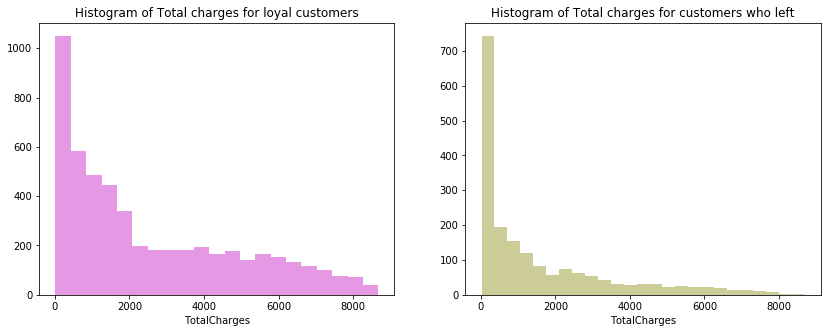

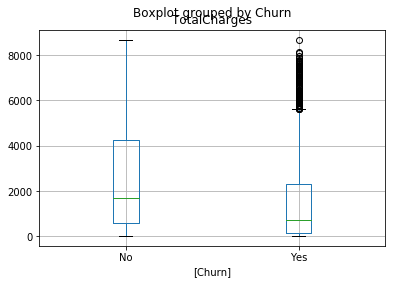

In [9]:
fig, ax = plt.subplots(figsize=(14,5))
_ = plt.subplot(1,2,1)
_ = sns.distplot(ch.loc[ch.Churn=='No','TotalCharges'],hist=True,kde=False,color='m')
_ = plt.title('Histogram of Total charges for loyal customers')
print("Mean Total Charge paid by Two groups\n",ch.groupby('Churn').TotalCharges.mean())
print("Median Total Charge paid by Two groups\n",ch.groupby('Churn').TotalCharges.median())
_ = plt.subplot(1,2,2)
_ = sns.distplot(ch.loc[ch.Churn=='Yes','TotalCharges'],hist=True,kde=False,color='olive')
_ = plt.title('Histogram of Total charges for customers who left')
_ = ch[['Churn','TotalCharges']].boxplot(by='Churn')

**Remarks**: If we assume that Total Charges are money paid to the company by a customer since getting the service, then no wonder the loyal customers have spent more on an average, because they have stayed longer. There are a few outliers in the boxplot of Churn group, because there are very few who would have stayed longer.

Mean Monthly Charge paid by Two groups
 Churn
No     61.265124
Yes    74.441332
Name: MonthlyCharges, dtype: float64
Median Monthly Charge paid by Two groups
 Churn
No     64.425
Yes    79.650
Name: MonthlyCharges, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


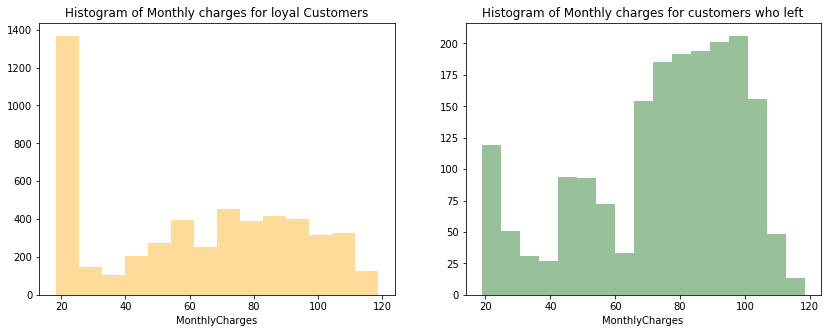

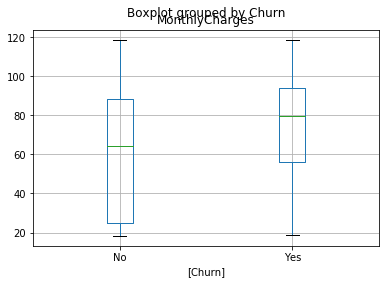

In [10]:
fig, ax = plt.subplots(figsize=(14,5))
_ = plt.subplot(1,2,1)
_ = sns.distplot(ch.loc[ch.Churn=='No','MonthlyCharges'],hist=True,kde=False,color='orange')
_ = plt.title('Histogram of Monthly charges for loyal Customers')
print("Mean Monthly Charge paid by Two groups\n",ch.groupby('Churn').MonthlyCharges.mean())
print("Median Monthly Charge paid by Two groups\n",ch.groupby('Churn').MonthlyCharges.median())
_ = plt.subplot(1,2,2)
_ = sns.distplot(ch.loc[ch.Churn=='Yes','MonthlyCharges'],hist=True,kde=False,color='darkgreen')
_ = plt.title('Histogram of Monthly charges for customers who left')
_ = ch[['Churn','MonthlyCharges']].boxplot(by='Churn')

**Remarks:** Clearly there is a significant number of customers in the Churn group whose monthly charges are towards higher end(\$70 to \$120). On the other hand, the loyal group has close to 1400 customers who pay around $20. We must recognize that the mean monthly charges does not give a good indication here. The large number of (possibly loyal old) customers with low charges push mean and mean down. The box plot clearly indicates that the churn group pays higher monthly charges. 

The telecom company might be charging old customers lesser charges because when they started decades ago, charges were lower and it was not increased to retain them or as a token of appreciating the loyalty. Later on we are going to apply clustering algorithm, taking only tenure and Monthly Charges features.

The box plot gives a better clue on the spread. Running any hypothesis test does not make sense here, as there is no way of knowing whether certain conditions are satisfied. Further, if this is the true population, and not a sample of the database, then we know all the statistics and there is no meaning to hypothesis tests. (They are done on samples, not on populations).

#### Examining the Correlations:

We have already hypothesized about possible relations between tenure and Charges, let us quantitatively and visually prove it

Correlations between numerical variables:



,tenure,MonthlyCharges,TotalCharges
tenure,1.00,0.25,0.83
MonthlyCharges,0.25,1.00,0.65
TotalCharges,0.83,0.65,1.00


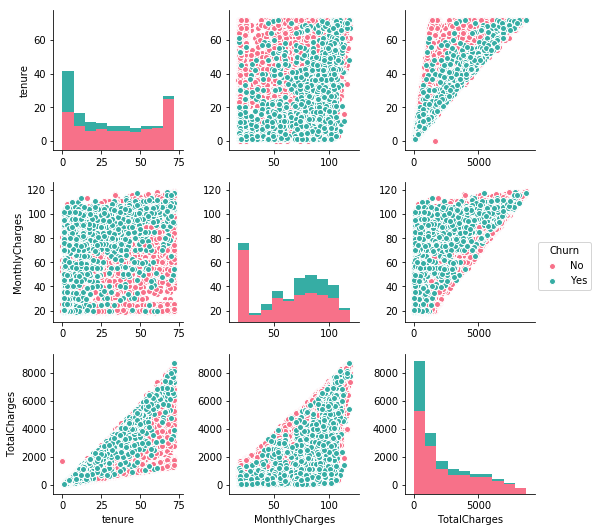

In [11]:
print("Correlations between numerical variables:\n")
_ = sns.pairplot(ch[['tenure', 'MonthlyCharges', 'TotalCharges','Churn']],hue='Churn',palette='husl')
round(ch[numvar].corr(),2)

**Remarks: ** The correlations tenure<->Total Charges and Total Charges<->Monthly Charges are very high at 0.83 and 0.65.
This is not desired, as the predictive models, like Linear/Logistic Regressions do not work well. Often the coefficients will be compromised between the two correlated variables. Sometimes it can give wrong sign to the coefficient.

This particular business problem has the need for right interpretation, because the wrong coefficient sign can make the opposite recommendation, which will harm the business.

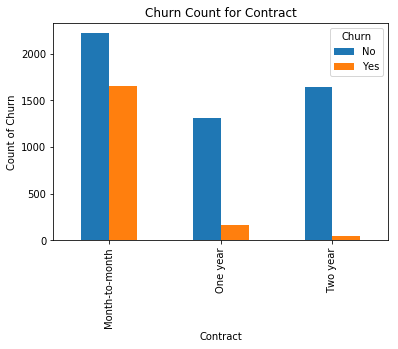

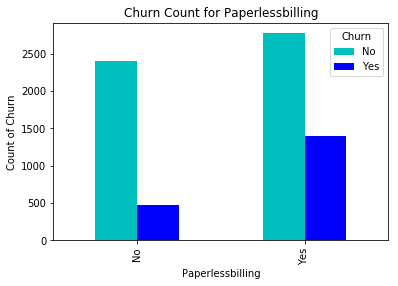

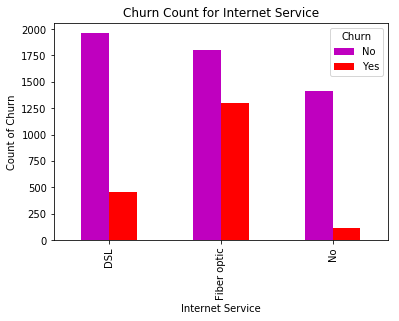

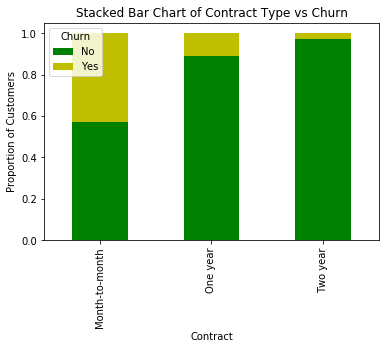

In [12]:
_ = pd.crosstab(ch.Contract,ch.Churn).plot.bar()
_ = plt.title('Churn Count for Contract')
_ = plt.xlabel('Contract')
_ = plt.ylabel('Count of Churn')
_ = pd.crosstab(ch.PaperlessBilling,ch.Churn).plot.bar(color='cb')
_ = plt.title('Churn Count for Paperlessbilling')
_ = plt.xlabel('Paperlessbilling')
_ = plt.ylabel('Count of Churn')
_ = pd.crosstab(ch.InternetService,ch.Churn).plot.bar(color='mr')
_ = plt.title('Churn Count for Internet Service')
_ = plt.xlabel('Internet Service')
_ = plt.ylabel('Count of Churn')
# The Contract plot as stacked bar for learning purposes
table=pd.crosstab(ch.Contract, ch.Churn)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,color='gy')
_ = plt.title('Stacked Bar Chart of Contract Type vs Churn')
_ = plt.xlabel('Contract')
_ = plt.ylabel('Proportion of Customers')

**Remark**: These plots serve two purposes, instead of a bar plot of mean rates of Churn for two categories in the same variable. They give counts and the relative counts of Churn Vs No churn. Across the categories, they tell us, which category has more members. This is helpful in deciding a few things. Let me explain with an example of Contract.

The month to month contract has high number of people in general and higher proportion of people Churning. The Contract with 2 years has the least members across categories and also within the category, relatively smaller proportion of the people Churn.

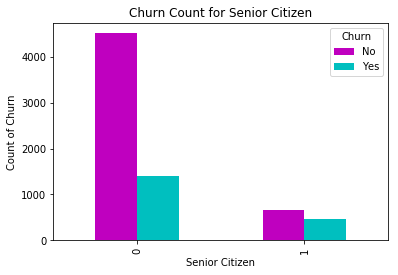

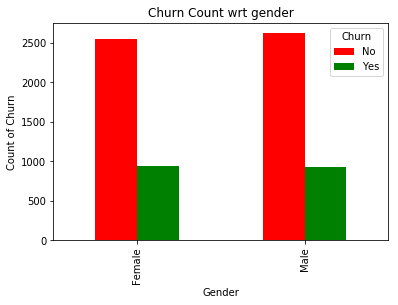

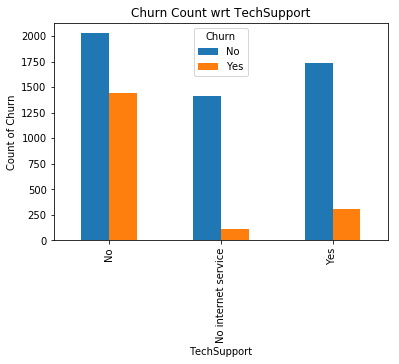

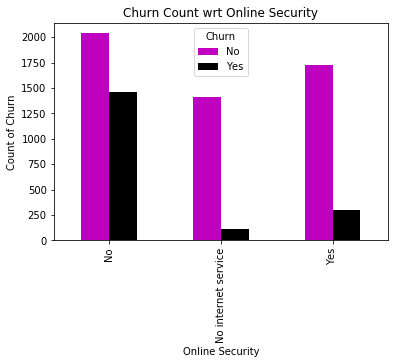

In [13]:
_ = pd.crosstab(ch.SeniorCitizen,ch.Churn).plot.bar(color='mc')
_ = plt.title('Churn Count for Senior Citizen')
_ = plt.xlabel('Senior Citizen')
_ = plt.ylabel('Count of Churn')
_ = plt.figure()
_ = pd.crosstab(ch.gender,ch.Churn).plot.bar(color='rg')
_ = plt.title('Churn Count wrt gender')
_ = plt.xlabel('Gender')
_ = plt.ylabel('Count of Churn')
_ = plt.figure()
_ = pd.crosstab(ch.TechSupport,ch.Churn).plot.bar()
_ = plt.title('Churn Count wrt TechSupport')
_ = plt.xlabel('TechSupport')
_ = plt.ylabel('Count of Churn')
_ = plt.figure()
_ = pd.crosstab(ch.OnlineSecurity,ch.Churn).plot.bar(color='mk')
_ = plt.title('Churn Count wrt Online Security')
_ = plt.xlabel('Online Security')
_ = plt.ylabel('Count of Churn')

**Remark**: 
+ We see that heights of all bars except in gender bar chart vary by great extent. 
+ There are less senior citizens in total, but among them churn proportion is higher than non senior citizen group.
+ As expected, Better tech support means less churn. Same with providing online security.

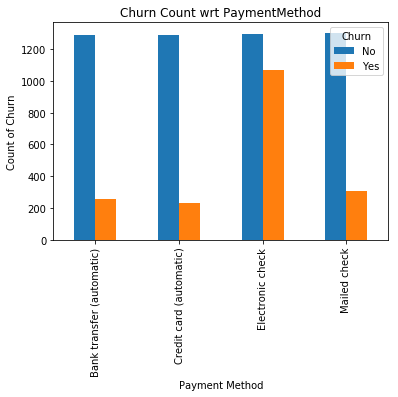

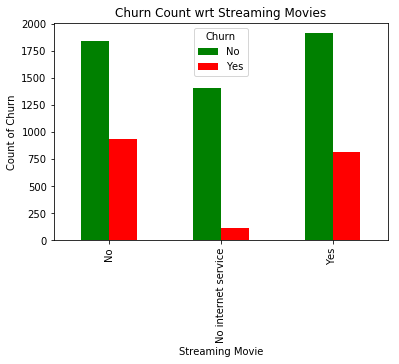

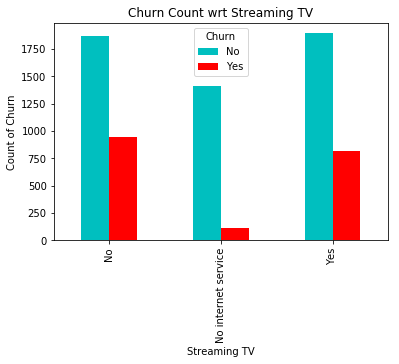

In [14]:
# Let us plot payment method and see
_ = pd.crosstab(ch.PaymentMethod,ch.Churn).plot.bar()
_ = plt.title('Churn Count wrt PaymentMethod')
_ = plt.xlabel('Payment Method')
_ = plt.ylabel('Count of Churn')
_ = plt.figure()
_ = pd.crosstab(ch.StreamingMovies,ch.Churn).plot.bar(color='greenk')
_ = plt.title('Churn Count wrt Streaming Movies')
_ = plt.xlabel('Streaming Movie')
_ = plt.ylabel('Count of Churn')
_ = plt.figure()
_ = pd.crosstab(ch.StreamingTV,ch.Churn).plot.bar(color='cr')
_ = plt.title('Churn Count wrt Streaming TV')
_ = plt.xlabel('Streaming TV')
_ = plt.ylabel('Count of Churn')

**Remarks**: 
+ We see that although there are 4 categories of payments, the automatic payment categories can be combined into one. There is negligible difference in the churn count and total counts. However, it is best not to combine them into one category, because any new data will have to undergo same procedure. Besides, the new dataset maynot have same properties.
+ In Streaming Movies and Streaming TV features, the Yes group has slightly low churn than the No streaming group. No internet service has lowest Churn. But total number of them is less than half of the other two categories put together.

In [15]:
num_var = ['SeniorCitizen','tenure','MonthlyCharges','TotalCharges']
ch1 = ch[num_var]
ch2 = ch.drop(num_var,axis=1)
ch3 = ch2.apply(lambda x: x.astype('category'))
ch  = ch3.apply(lambda x: x.cat.codes)
ch[num_var] = ch1

In [16]:
# Examine mean churn rates for a few features' various categories
print("Mean Churn Rate for various contract types",ch.groupby('Contract')['Churn'].mean())
print("Mean Churn Rate for Gender:",ch.groupby('gender')['Churn'].mean())
print("Mean Churn Rate for TechSupport:",ch.groupby('TechSupport')['Churn'].mean())
print("Mean Churn Rate for Senior Citizen:",ch.groupby('SeniorCitizen')['Churn'].mean())
print("Mean Churn Rate for Online Security:",ch.groupby('OnlineSecurity')['Churn'].mean())

Mean Churn Rate for various contract types Contract
0    0.427097
1    0.112695
2    0.028319
Name: Churn, dtype: float64
Mean Churn Rate for Gender: gender
0    0.269209
1    0.261603
Name: Churn, dtype: float64
Mean Churn Rate for TechSupport: TechSupport
0    0.416355
1    0.074050
2    0.151663
Name: Churn, dtype: float64
Mean Churn Rate for Senior Citizen: SeniorCitizen
0    0.236062
1    0.416813
Name: Churn, dtype: float64
Mean Churn Rate for Online Security: OnlineSecurity
0    0.417667
1    0.074050
2    0.146112
Name: Churn, dtype: float64


**Remarks: ** Except gender, other groups have variable mean churn rates. These will be very helpful in modeling.

In [17]:
# Phone service is redundant.
print("Multiple Lines category counts:\n",ch.MultipleLines.value_counts())
print("Phone Lines category counts:\n",ch.PhoneService.value_counts())

Multiple Lines category counts:
 0    3390
2    2971
1     682
Name: MultipleLines, dtype: int64
Phone Lines category counts:
 1    6361
0     682
Name: PhoneService, dtype: int64


**Remark:**From the above, Phone service is a subset of multiple lines. It does not contain any new information. Hence we choose to omit it. 

We can not rule out the possibility that the digits in customerID has some kind of information encoded. It can be taken up as future work. At this time, for ease of analysis, let us drop it.

In [18]:
y = ch.Churn
X = ch.drop(['customerID','Churn','PhoneService'],axis=1,inplace=False)

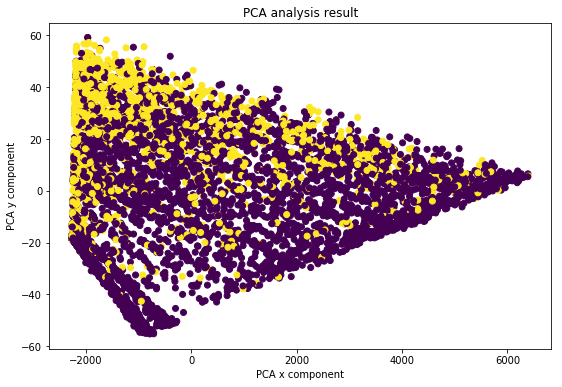

In [19]:
# We will reduce all features to 2D by PCA.
from sklearn.decomposition import PCA
pca = PCA()
_ = plt.figure(figsize=(9,6))
xx = pca.fit_transform(X)
xs = xx[:,0]
ys = xx[:,1]
_ = plt.scatter(xs,ys,c=y)
_ = plt.title('PCA analysis result')
_ = plt.xlabel("PCA x component")
_ = plt.ylabel("PCA y component")

**Remark**: The PCA indicates that there is some kind of skew. This must be due to high correlation between Tenure and TotalCharges. Since Charges is also captured in Monthly Charges, let us keep tenure and drop TotalCharges. Now let us do a PCA and see what happens

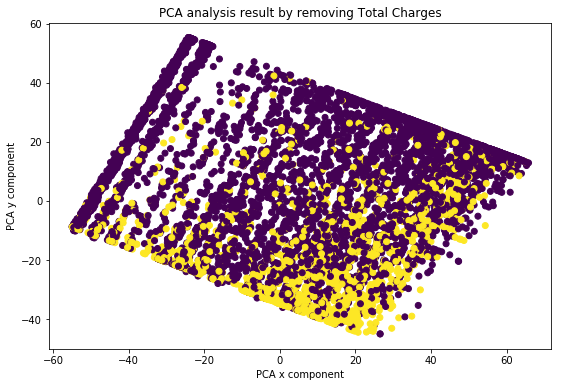

In [20]:
X = ch.drop(['customerID','Churn','PhoneService','TotalCharges'],axis=1,inplace=False)
_ = plt.figure(figsize=(9,6))
xx = pca.fit_transform(X)
xs = xx[:,0]
ys = xx[:,1]
_ = plt.scatter(xs,ys,c=y)
_ = plt.title('PCA analysis result by removing Total Charges')
_ = plt.xlabel("PCA x component")
_ = plt.ylabel("PCA y component")

**Remarks: ** This one definitely looks nicer. If we need to use logitic regression, we must drop the TotalCharges so that the correlated columns do not have too much influence on the model.

In [21]:
X.nunique()

gender                 2
Partner                2
Dependents             2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
SeniorCitizen          2
tenure                73
MonthlyCharges      1585
dtype: int64

#### Preparing the data for Predictive Analysis, by one-hot encoding
Creating one hot encoding to suit logistic regression is important for the correct interpretation of the features by the model. We do that below, and then drop original columns and the last column of each variable, as it is correlated to the others.

In [22]:
X = ch.drop(['customerID','Churn','TotalCharges','PhoneService'],axis=1,inplace=False)
cat_vars=['MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaymentMethod']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(ch[var], prefix=var,drop_first=True)
    X1=X.join(cat_list)
    X=X1
X.drop(cat_vars,axis=1,inplace=True) # Originals need to be dropped
print("Number of variables:",len(X.columns))

Number of variables: 28


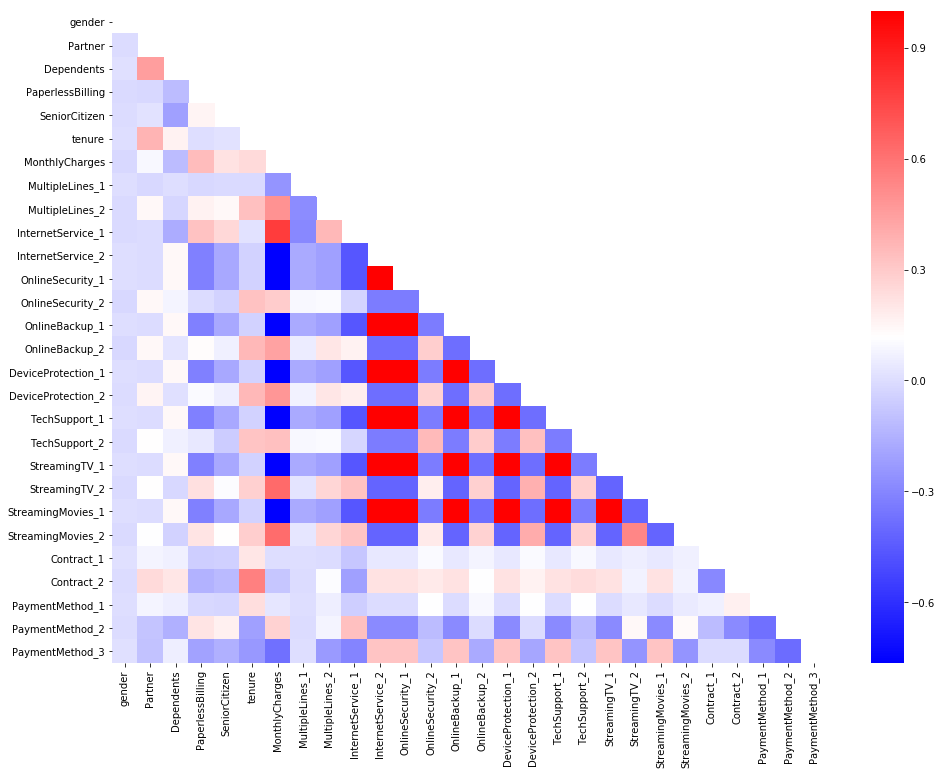

In [23]:
# Checking correlations as we intend to do logreg.
# Plotting correlation for top 10 features
# Ref : https://matplotlib.org/examples/color/colormaps_reference.html for colormap
_ = plt.figure(figsize=(16,12))
mask = np.zeros_like(X.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(X.corr(),mask=mask,cmap='bwr')

Further remove correlated ones.

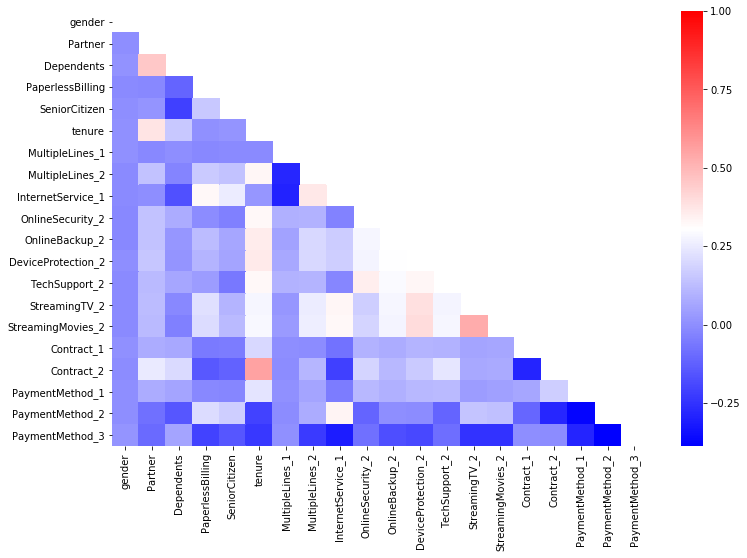

In [24]:
X.drop(['StreamingMovies_1','StreamingTV_1','TechSupport_1','DeviceProtection_1','OnlineBackup_1','InternetService_2','MonthlyCharges','OnlineSecurity_1'],axis=1,inplace=True)
_ = plt.figure(figsize=(12,8))
mask = np.zeros_like(X.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(X.corr(),mask=mask,cmap='bwr')

Wow! That is much better

### 4) Training and Testing Predictive Models
 
The goals of Predictive Model fitting are,
+ To identify the customers with high probability of switching to competition
+ To identify the major causes behind the tendency to leave (feature importance)
+ To make predictions and assess the capacity of the model for future data (Predictive power)
+ Use all the results and make recommendations to the telecom company.

#### Metrics to assess the model:
We are interested in customers who have tendency to go away (i.e. label 1). We may not mind a few false alarms especially if the measures taken to retain them is relatively inexpensive compared to the loss due to missing the true alarms. The measures taken on the customers who had no intention to leave can result in improved customer satisfaction and hence long term benefits.

We want high recall on class 1. 

In [25]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Logistc Regression Classifier

We are performing standardization and also dropping correlated variables. 

Confusion Matrix:
           No  Yes
Pred N  1497  573
Pred Y   146  602
Report:
              precision    recall  f1-score   support

          0       0.91      0.72      0.81      2070
          1       0.51      0.80      0.63       748

avg / total       0.81      0.74      0.76      2818

Dev Set Accuracy 0.744854506742
Train set Accuracy 0.747455621302


Text(0.5,0,'False Positive Rate')

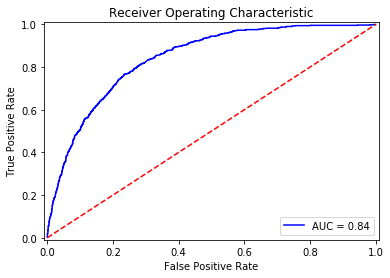

In [26]:
scaler = StandardScaler()
X_new = scaler.fit_transform(X)
Xtrain, Xdev, ytrain,ydev = train_test_split(X_new,y,test_size=0.4,random_state=42,stratify=y)
# This is commented because hyperparameter tuning is not done currently.
#Xdev, Xtest, ydev,ytest = train_test_split(Xt,yt,test_size=0.5,random_state=42,stratify=yt)
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(Xtrain,ytrain)
yp_dev = logreg.predict(Xdev)
lr=yp_dev
print("Confusion Matrix:\n",pd.DataFrame(confusion_matrix(ydev,yp_dev),index=['Pred N','Pred Y'],columns=['No','Yes']))
print("Report:\n",classification_report(ydev,yp_dev))
print("Dev Set Accuracy",accuracy_score(ydev,yp_dev))
print("Train set Accuracy",accuracy_score(ytrain,logreg.predict(Xtrain)))
yprob = logreg.predict_proba(Xdev)
false_positive_rate, true_positive_rate, thresholds = roc_curve(ydev, yprob[:,1],pos_label=1)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.01,1.01])
plt.ylim([-0.01,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

**Remarks:** The model is having similar accuracy on dev and train set. Since the class weight is set to balanced, the model has adjusted for imbalance by sampling methods. In logistic regression model, one can not do better than this, once the training and dev set accuracy is equal.

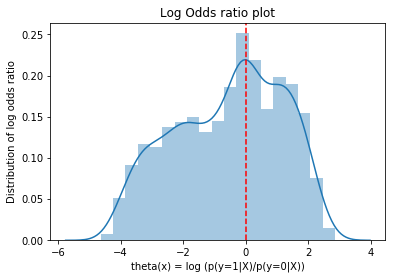

In [27]:
# Plotting the log odds ratio
theta_x = np.log(yprob[:,1]/yprob[:,0]) # Theta x is linear in coefficients
_ = sns.distplot(theta_x,hist=True)
_ = plt.axvline(0,linestyle='--',color='r')
_ = plt.title('Log Odds ratio plot')
_ = plt.xlabel('theta(x) = log (p(y=1|X)/p(y=0|X))')
_ = plt.ylabel('Distribution of log odds ratio')

In [28]:
# Coefficients with LogReg
coeffs = logreg.coef_[0,np.argsort(abs(logreg.coef_[0,:]))[::-1]]
names = list(X.columns[np.argsort(abs(logreg.coef_[0,:]))[::-1]])
print("Coefficients and their values in decreasing importance")
pd.DataFrame(np.round(coeffs,2),index=names,columns=['Coeff value'])

Coefficients and their values in decreasing importance


,Coeff value
tenure,-0.75
Contract_2,-0.68
InternetService_1,0.52
Contract_1,-0.34
PaymentMethod_2,0.22
PaperlessBilling,0.20
MultipleLines_1,0.18
StreamingMovies_2,0.17
MultipleLines_2,0.14
Dependents,-0.13


**Interpretation:** The negative coefficients indicate that customers with higher magnitude for negative coefficient tend to remain loyal and higher for positive coefficients indicate the opposite. We need to map it back to the meaningful text.

**Note on Feature Importance: **
+ Company has no direct control over the tenture of the customer. The negative value just indicates that higher tenure customers are more likely to continue the subscription. Hence the company can continue to maintain a good relationship with them.
+ Contract 2 corresponds 2 year contract, Contract 1 corresponds to 1 year contract. Both have negative coefficients, 2 year being higher magnitude. This is in agreement with EDA results. The company better try to give more incentive to get into 2 year contract, the third type. This has least customer churn rate. 

**Scikit-learn's RFE**: Scikit Learn has a nice package called Recursive feature elimination (RFE). Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of RFE is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

Index(['Dependents', 'PaperlessBilling', 'SeniorCitizen', 'tenure',
       'MultipleLines_1', 'MultipleLines_2', 'InternetService_1',
       'OnlineSecurity_2', 'DeviceProtection_2', 'TechSupport_2',
       'StreamingTV_2', 'StreamingMovies_2', 'Contract_1', 'Contract_2',
       'PaymentMethod_2'],
      dtype='object')
Report:
              precision    recall  f1-score   support

          0       0.84      0.89      0.87      2070
          1       0.65      0.54      0.59       748

avg / total       0.79      0.80      0.79      2818

Dev Set Accuracy 0.799858055358
Train set Accuracy 0.803786982249


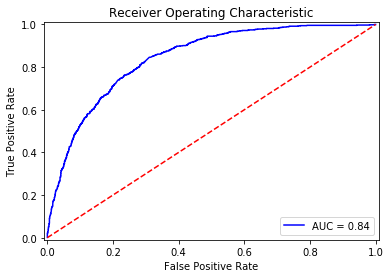

In [29]:
# Trying Feature Selection by limiting to 10
from sklearn.feature_selection import RFE
model = LogisticRegression(class_weight='balanced')
rfe = RFE(model, 15)
rfe = rfe.fit(Xtrain, ytrain)
Xp = X.loc[:,X.columns[rfe.support_]]
print(X.columns[rfe.support_])
X_new1 = scaler.fit_transform(Xp)
Xtrain1, Xt, ytrain1,yt = train_test_split(X_new1,y,test_size=0.4,random_state=42,stratify=y)
logreg = LogisticRegression()
logreg.fit(Xtrain1,ytrain1)
yp = logreg.predict(Xt)
print("Report:\n",classification_report(yt,yp))
print("Dev Set Accuracy",accuracy_score(yt,yp))
print("Train set Accuracy",accuracy_score(ytrain1,logreg.predict(Xtrain1)))
yprob = logreg.predict_proba(Xt)
false_positive_rate, true_positive_rate, thresholds = roc_curve(yt, yprob[:,1],pos_label=1)
roc_auc = auc(false_positive_rate, true_positive_rate)
_ = plt.title('Receiver Operating Characteristic')
_ = plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
_ = plt.legend(loc='lower right')
_ = plt.plot([0,1],[0,1],'r--')
_ = plt.xlim([-0.01,1.01])
_ = plt.ylim([-0.01,1.01])
_ = plt.ylabel('True Positive Rate')
_ = plt.xlabel('False Positive Rate')

**Remarks:** Even though the class weight is given as balanced, RFE doesn't seem to take it. Could be a bug in sklearn

In [30]:
# Coefficients with LogReg
coeffs = logreg.coef_[0,np.argsort(abs(logreg.coef_[0,:]))[::-1]]
names = list(Xp.columns[np.argsort(abs(logreg.coef_[0,:]))[::-1]])
print("Coefficients and their values in decreasing importance")
pd.DataFrame(np.round(coeffs,2),index=names,columns=['Coeff value'])

Coefficients and their values in decreasing importance


,Coeff value
tenure,-0.81
Contract_2,-0.64
InternetService_1,0.52
Contract_1,-0.32
PaperlessBilling,0.21
PaymentMethod_2,0.20
MultipleLines_1,0.19
MultipleLines_2,0.16
StreamingMovies_2,0.15
Dependents,-0.13


**Remarks**: The feature importance is almost agreeing with those obtained without RFE.

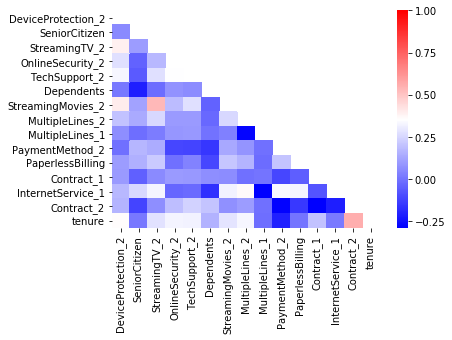

In [31]:
mask = np.zeros_like(X[list(Xp.columns[np.argsort(abs(logreg.coef_[0,:]))])].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(X[list(Xp.columns[np.argsort(abs(logreg.coef_[0,:]))])].corr(),mask=mask,cmap='bwr')

### Random Forest Classifier
There is no need to drop correlated features for Random Forest. It selects best features at every node of every tree by itself

Confusion Matrix:
 [[1474  596]
 [ 152  596]]
Report:
              precision    recall  f1-score   support

          0       0.91      0.71      0.80      2070
          1       0.50      0.80      0.61       748

avg / total       0.80      0.73      0.75      2818

Dev Set Accuracy 0.734563520227
Train set Accuracy 0.751952662722


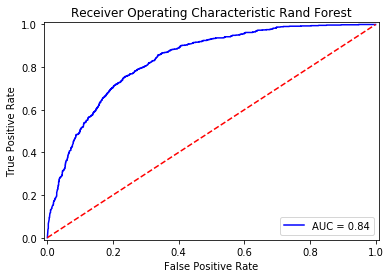

In [32]:
## Try fitting the Random forest.
X_rf = ch.drop(['customerID','Churn'],axis=1,inplace=False).copy()  # New one because rand forest requires no encoding 
Xtrain, Xdev, ytrain,ydev = train_test_split(X_rf,y,test_size=0.4,random_state=42,stratify=y)
rand_forest = RandomForestClassifier(25,'entropy',4,10,class_weight='balanced',oob_score=True)
rand_forest.fit(Xtrain,ytrain)
yp_dev = rand_forest.predict(Xdev)
rf = yp_dev
print("Confusion Matrix:\n",confusion_matrix(ydev,yp_dev))
print("Report:\n",classification_report(ydev,yp_dev))
print("Dev Set Accuracy",accuracy_score(ydev,yp_dev))
print("Train set Accuracy",accuracy_score(ytrain,rand_forest.predict(Xtrain)))
yprob = rand_forest.predict_proba(Xdev)
false_positive_rate, true_positive_rate, thresholds = roc_curve(ydev, yprob[:,1],pos_label=1)
roc_auc = auc(false_positive_rate, true_positive_rate)
_ = plt.title('Receiver Operating Characteristic Rand Forest')
_ = plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
_ = plt.legend(loc='lower right')
_ = plt.plot([0,1],[0,1],'r--')
_ = plt.xlim([-0.01,1.01])
_ = plt.ylim([-0.01,1.01])
_ = plt.ylabel('True Positive Rate')
_ = plt.xlabel('False Positive Rate')

This is an overfitting model, so there is scope for improvement. For now, since we are more interested in feature importance, this is fine enough.

In [33]:
feature_labels = np.array(list(X_rf.columns))
importance = rand_forest.feature_importances_
feature_indexes_by_importance = importance.argsort()[::-1]
pd.DataFrame(np.round(importance[feature_indexes_by_importance] *100.0,2),index = feature_labels[feature_indexes_by_importance],columns=['% feature importance'])

,% feature importance
TechSupport,21.27
Contract,18.63
tenure,13.16
OnlineSecurity,11.10
OnlineBackup,7.11
MonthlyCharges,7.04
TotalCharges,6.81
InternetService,6.16
PaymentMethod,2.64
PaperlessBilling,1.90


Index(['Partner', 'Dependents', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'tenure', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')
Confusion Matrix:
 [[1431  639]
 [ 134  614]]
Report:
              precision    recall  f1-score   support

          0       0.91      0.69      0.79      2070
          1       0.49      0.82      0.61       748

avg / total       0.80      0.73      0.74      2818

Dev Set Accuracy 0.725691980128
Train set Accuracy 0.744378698225


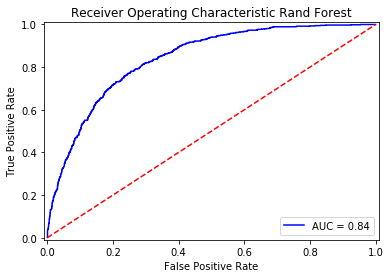

In [34]:
rfe = RFE(rand_forest,16)
rfe = rfe.fit(Xtrain, ytrain)
Xprf = X_rf.loc[:,X_rf.columns[rfe.support_]]
print(X_rf.columns[rfe.support_])
X_new1 = scaler.fit_transform(Xprf)
Xtrain1, Xt, ytrain1,yt = train_test_split(X_new1,y,test_size=0.4,random_state=42,stratify=y)
rand_forest = RandomForestClassifier(300,'entropy',4,min_samples_leaf=3,class_weight='balanced')
rand_forest.fit(Xtrain1,ytrain1)
yp_dev = rand_forest.predict(Xt)
print("Confusion Matrix:\n",confusion_matrix(yt,yp_dev))
print("Report:\n",classification_report(yt,yp_dev))
print("Dev Set Accuracy",accuracy_score(yt,yp_dev))
print("Train set Accuracy",accuracy_score(ytrain1,rand_forest.predict(Xtrain1)))
yprob = rand_forest.predict_proba(Xt)
false_positive_rate, true_positive_rate, thresholds = roc_curve(yt, yprob[:,1],pos_label=1)
roc_auc = auc(false_positive_rate, true_positive_rate)
_ = plt.title('Receiver Operating Characteristic Rand Forest')
_ = plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
_ = plt.legend(loc='lower right')
_ = plt.plot([0,1],[0,1],'r--')
_ = plt.xlim([-0.01,1.01])
_ = plt.ylim([-0.01,1.01])
_ = plt.ylabel('True Positive Rate')
_ = plt.xlabel('False Positive Rate')

In [35]:
feature_labels = np.array(list(Xprf.columns))
importance = rand_forest.feature_importances_
feature_indexes_by_importance = importance.argsort()[::-1]
pd.DataFrame(np.round(importance[feature_indexes_by_importance] *100.0,2),index = feature_labels[feature_indexes_by_importance],columns=['% feature importance'])

,% feature importance
Contract,31.34
OnlineSecurity,13.69
TechSupport,13.64
tenure,12.45
TotalCharges,7.07
MonthlyCharges,6.73
InternetService,5.51
OnlineBackup,2.78
PaymentMethod,2.13
PaperlessBilling,1.21


### 5) Comparing The Results, Feature Importance: 
Both LogReg and RF models give similar results in terms of overall accuracy and recall on the Churn class, if class_weight parameter is set to balanced.

There are top 3 features common between Logistic Regression and Random Forest. They are tenure,Monthly Charges and Contract. 

To know the action items in terms of monthly charges, we will be doing k-means clustering and further analysis. Before we move on to that, here is the result of decision trees which was tried before random forests.

Test accuracy 0.734563520227
Train accuracy 0.757159763314
Confusion Matrix:
 [[1482  588]
 [ 160  588]]
Report:
              precision    recall  f1-score   support

          0       0.90      0.72      0.80      2070
          1       0.50      0.79      0.61       748

avg / total       0.80      0.73      0.75      2818



Text(0.5,0,'False Positive Rate')

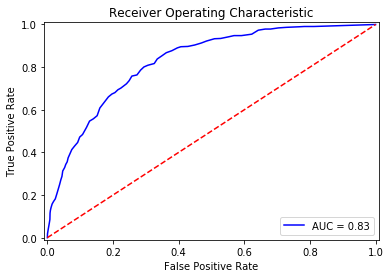

In [36]:
from os import system
dt = DecisionTreeClassifier(min_weight_fraction_leaf=0.01,class_weight='balanced')
dt.fit(Xtrain,ytrain)
dotfile = open("./dtree2.dot", 'w')
tree.export_graphviz(dt, out_file = dotfile, feature_names = Xtrain.columns)
dotfile.close()
system("cd C:/Users/Aparn/DataScience/Projects/mini_projects/customer_retention")
system("dot -Tpng dtree2.dot -o dtree2.png")
yp_dev = dt.predict(Xdev)
dtd=yp_dev
print("Test accuracy",accuracy_score(ydev,yp_dev))
print("Train accuracy",accuracy_score(ytrain,dt.predict(Xtrain)))
print("Confusion Matrix:\n",confusion_matrix(ydev,yp_dev))
print("Report:\n",classification_report(ydev,yp_dev))
yprob = dt.predict_proba(Xdev)
false_positive_rate, true_positive_rate, thresholds = roc_curve(ydev, yprob[:,1],pos_label=1)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.01,1.01])
plt.ylim([-0.01,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [37]:
# We try majority Voting between Logistic reg with RFE, Random Forest and Decision Tree.
maj_vot = 1*((lr+rf+dtd) > 1)
print("Accuracy score with Majority voting",accuracy_score(ydev,(maj_vot)))

Accuracy score with Majority voting 0.743435060326


### K-Means Clustering:

Clustering is done on tenure and Monthly Charges. This will help understand the counterintuitve finding (negative coefficient with logreg) on the Monthly charges.
Churn population and non-Churn population are separately clustered into 3 and compared.


Cluster Centers for  Churn are at:
[ 47.45558087  93.86503417] 438
[  8.82172996  83.58238397] 949
[  9.14315353  38.77178423] 482
Cluster Centers for no Churn are at:
[ 32.54916201  24.75938547] 1790
[ 59.20247046  89.49406552] 1862
[ 17.00985545  69.66392904] 1522


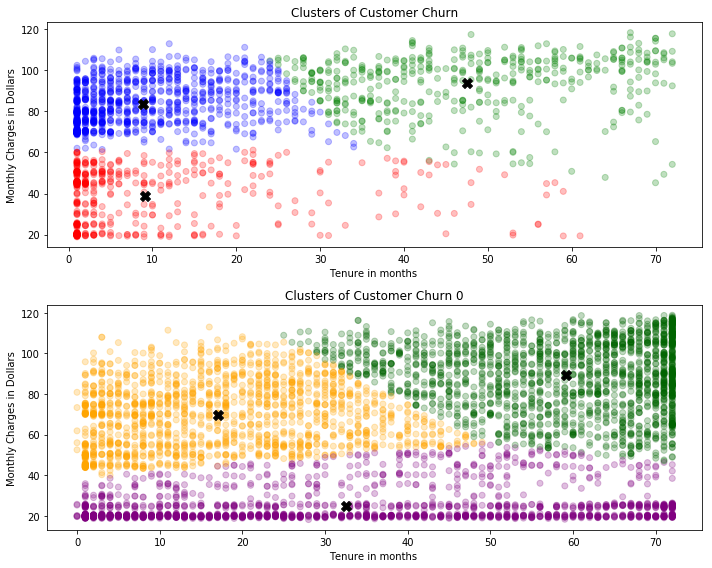

In [38]:
# Import KMeans Model
from sklearn.cluster import KMeans

# Graph and create 3 clusters of Customer Churn
kmeans = KMeans(n_clusters=3,random_state=2)
kmeans.fit(ch[ch.Churn==1][["tenure","MonthlyCharges"]])

kmeans_colors = ['green' if c == 0 else 'blue' if c == 2 else 'red' for c in kmeans.labels_]
fig, ax = plt.subplots(figsize=(10, 8))
plt.subplot(2,1,1) #figsize=(10, 6))
plt.scatter(x="tenure",y="MonthlyCharges", data=ch[ch.Churn==1],
            alpha=0.25,color = kmeans_colors)
plt.xlabel("Tenure in months ")
plt.ylabel("Monthly Charges in Dollars")
plt.scatter(x=kmeans.cluster_centers_[:,0],y=kmeans.cluster_centers_[:,1],color="black",marker="X",s=100)
plt.title("Clusters of Customer Churn")
print("Cluster Centers for  Churn are at:")
print(kmeans.cluster_centers_[0,:],(kmeans.labels_==0).sum())
print(kmeans.cluster_centers_[2,:],(kmeans.labels_==2).sum())
print(kmeans.cluster_centers_[1,:],(kmeans.labels_==1).sum())

plt.subplot(2,1,2)

# Graph and create 3 clusters of Customer Churn
kmeans = KMeans(n_clusters=3,random_state=2)
kmeans.fit(ch[ch.Churn==0][["tenure","MonthlyCharges"]])

kmeans_colors = ['darkgreen' if c == 0 else 'orange' if c == 2 else 'purple' for c in kmeans.labels_]

plt.scatter(x="tenure",y="MonthlyCharges", data=ch[ch.Churn==0],
            alpha=0.25,color = kmeans_colors)
plt.xlabel("Tenure in months ")
plt.ylabel("Monthly Charges in Dollars")
plt.scatter(x=kmeans.cluster_centers_[:,0],y=kmeans.cluster_centers_[:,1],color="black",marker="X",s=100)
plt.title("Clusters of Customer Churn 0")
print("Cluster Centers for no Churn are at:")
print(kmeans.cluster_centers_[1,:],(kmeans.labels_==1).sum())
print(kmeans.cluster_centers_[0,:],(kmeans.labels_==0).sum())
print(kmeans.cluster_centers_[2,:],(kmeans.labels_==2).sum())
_ = plt.tight_layout()

**Remarks**:  Will lowering Monthly Charges help to retain the business?

Well, it is not an yes or no answer. There is no one size fits all.
+ In the Churn group, There are relatively less customers in the lower right corner of the plot. Hence, trying to evaluate what incentives might make this group change their decision will not be of much benefit to the business.
+ Interesting that cluster means of red and blue group in the first plot has similar x value, that is customers who left around 8 months on an average. That makes it easy to analyze these two groups in terms of monthly charges.
+ There is a bunch of customers who pay less than 60 bucks per month and yet stop the subscribing (The red cluster). These people's reason may not have to do with Charges, but mainly quality. Some of these customers who might be willing to pay for the quality, and there is no point in reducing the already low monthly Charges.
+ The blue cluster members, at least some of them, perhaps those who do not stay beyond 24 months are likely to change their mind if the monthly charges are lowered.
+ The green cluster members might have some other reasons for changing despite being subscribers for 24+ months with the company. It is better to dig more data by conducting short surveys on some people and if the response pointed at monthly charges as the cause for majority of them, then reducing the monthly charges will help.
+ A comment on reducing charges: This will benefit in the long run because of volumes although temporarily it will result in loss of revenue.

-------------

### 6) Recommendations to retain the customers:
+ The company should spend sometime investigating why there was a drop in customer base about 5.5 years ago. It might throw some light on what aspect of the company needs improvement even today.
+ The company needs to keep collecting feedback from customers on what more they want, so that before they consider stopping the subscription, some of those points in their feedback can be implemented. 
+ The feedback from older customers are more reliable than the new customers. However, new customers might have more tendency for knee jerk reaction if their feedback is not implemented. Hence give appropriate weightage to their based on the tenure, because tenure is highly correlated with the customer decision to leave or not. Once the customers cross around 2 years tenture, their tendency to switch drastically reduces as per the current data. Hence prioritize newer customers.
+ The company needs to give more commission to the sales people who convince a customer to get into 2 year contract, and also one year contract in that order, compared to month to month contract.
+ The company needs to improve on the quality of their technical support, internet service, streaming, online security, online backup and many other factors which will be available in a detailed report.
+ The company could encourage automatic payment by giving a small discount for enrolling into autopay.
+ Employers need to be upto date with the current technology. The HR can encourage continuous education by allocating a budget for that and motivating employees towards learning more.
+ If needed, the company can reduce the monthly charges on certain group of customers who leave for that reason. This will help revenue due to volumes in retention.
+ The company can watch the effect of above steps on Churn rate. Another analysis of customer behavior is recommended after 6 months.

### 7) Scope for future work:
+ On the current dataset, one could split the table of records according to the K-means clusters above and do further analysis to customize the incentives.
+ More predictive models could be tried, however, there is no guarantee of better accuracy, as we have seen similar accuracy witn logistic regression and random forest. This actually means most of the variance in the data is explained.
+ One could collect more data through surveys, analyze them using NLP techniques and take more measures.
+ There is a scope to collect historical data on company customers over a few decades, and fight out clear reason for customer drop happened 70 years ago.

### A Final Note:

It was fun doing this small project. Made me understand what more I need to work on. In the process I learnt a lot about Machine Learning basics and more importantly, metrics to measure the goodness of the model. Learnt that accuracy is definitely not a good enough measure in case of imbalanced classes. In a problem where feature ranking is important, removing correlated coefficients might result in slight drop of accuracy, but it can give right insights.  

Thanks for taking time to go through this project. Feedback is highly appreciated. Please email [me](mailto:aparnack@gmail.com) to discuss your views

References:

+ How to plot AUC is [here](https://datamize.wordpress.com/2015/01/24/how-to-plot-a-roc-curve-in-scikit-learn/)
+ Colormap codes for heatmap [here](https://matplotlib.org/examples/color/colormaps_reference.html for colormap)
+ [Here](https://towardsdatascience.com/predict-customer-churn-with-r-9e62357d47b4) is another implementation of this problem by Susan Li in Towards Data Science blog